In [2]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from utils import *

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'adult'
seed = 1
np.random.seed(seed)

In [3]:
from ctgan import load_demo
data = load_demo()

categorical_features = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
]


In [4]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.860


Epoch 1, Loss G: 0.017519194549819893, loss_bb: 0.017519194549819893
Epoch 2, Loss G: 0.017649156666023097, loss_bb: 0.017649156666023097
Epoch 3, Loss G: 0.01790657180735145, loss_bb: 0.01790657180735145
Epoch 4, Loss G: 0.01772983591241804, loss_bb: 0.01772983591241804
Epoch 5, Loss G: 0.01761252085611704, loss_bb: 0.01761252085611704
Epoch 6, Loss G: 0.017980515524506434, loss_bb: 0.017980515524506434
Epoch 7, Loss G: 0.01779114249019001, loss_bb: 0.01779114249019001
Epoch 8, Loss G: 0.017730985951055347, loss_bb: 0.017730985951055347
Epoch 9, Loss G: 0.01768804593322428, loss_bb: 0.01768804593322428
Epoch 10, Loss G: 0.017741717581534616, loss_bb: 0.017741717581534616
Epoch 11, Loss G: 0.01765381785180591, loss_bb: 0.01765381785180591
Epoch 12, Loss G: 0.01782522796900314, loss_bb: 0.01782522796900314
Epoch 13, Loss G: 0.017911509688857602, loss_bb: 0.017911509688857602
Epoch 14, Loss G: 0.01781412980278936, loss_bb: 0.01781412980278936
Epoch 15, Loss G: 0.0177171538715914, loss_bb

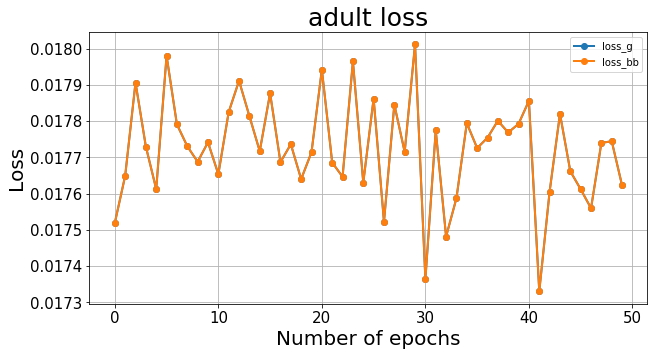

In [6]:
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))
batch_size = 500
epochs = 50
confidence_level = 0.9 
gen_lr = 2e-5
loss = 'focal'

rf_ctgan = CTGANSynthesizer(batch_size=batch_size, 
                            blackbox_model=rf, 
                            preprocessing_pipeline=preprocessor, 
                            bb_loss=loss
                            )

hist = rf_ctgan.fit(train_data=z, 
                    epochs=epochs,
                    confidence_level=confidence_level,
                    gen_lr=gen_lr,
                    )

# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")

plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
print()

In [ ]:
# check confidence for the generated samples
samples = 100
confidence_levels = [confidence_level]

for c in confidence_levels:
#     rf_ctgan = CTGANSynthesizer.load(f"{MODELS_PATH}/ctgan_c_{c}.pkl")
    gen_data = rf_ctgan.sample(samples)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores

    counts = pd.value_counts(y_conf_gen, bins=10, sort=False)
    plt.figure()
    ax = counts.plot.bar(rot=0, grid=True, color='#607c8e', figsize=(15,5))
    ax.set_xticklabels([str(interval) for interval in counts.index], fontsize=11)
    ax.set_ylabel('Frequency', fontsize=15)

    ax.set_title(f'Scores of generated {samples} samples (c={c})', fontsize=25)

In [ ]:
# find samples s such that s.confidence > c
indecies = np.argwhere(y_conf_gen>confidence_level).squeeze()
print(f"indecies:\n\t{indecies}\nconfidence levels:\n\t{y_conf_gen[indecies]}")
indecies = indecies if indecies.shape != () else [indecies] # avoide no shape arrays

In [ ]:
# inverse the generated data
scaler = get_scaler(preprocessor)
gen_data_above_c_before = gen_data.iloc[indecies]
gen_data_above_c = pd.DataFrame(scaler.inverse_transform(gen_data_above_c_before))

In [ ]:
euclidean_scores, cosine_scores = calc_scores(gen_data_above_c, X_train)
print(f"euclidean_scores:\n\t{euclidean_scores}")
print(f"cosine_scores:\n\t{cosine_scores}")